## Cloze task data filtering

drop all rows were we don't have a contex as a stimulus

In [4]:
import pandas as pd
row_data = pd.read_excel('cloze_task_raw_data.xlsx')
print(row_data.shape)
row_data = row_data[row_data['shown'] != 'Введите первое слово']
print(row_data.shape)

(64645, 16)
(57836, 16)


In [10]:
def clear(x):
    flag=0
    if x.isdigit():
        return 0
    if (len(x)==1) and (x not in 'ксявуоиа'):
        flag+=1
    for i in x:
        if i not in 'ячсмитьбюэждлорпавыфйцукенгшщзхъЯЧСМИТЬБЮФЫВАПРОЛДЖЭЪХЗЩЙЦШУГКНЕ':
             flag+=1
    if flag==0:
        return x
    else:
        return 0
row_data.answer = row_data.answer.astype(str)
row_data.answer = row_data.answer.apply(clear)
row_data = row_data[row_data['answer']!=0]
row_data.shape

(57346, 16)

Count number of different answer for each stimulus and alse a index of confusion for rows.
If in experement we have 16 attempts to add the contex, when index of confusion is equel 16/max(all quantities of responses for each stimulus). Smaller the value of confuision, than we can be more confident about this example)

In [11]:
sub_data = row_data[['shown', 'answer', 'word.id']]
grop_data = sub_data[['shown', 'answer']].groupby('shown').size()
grop_data = grop_data.reset_index(level=['shown'])
grop_data.columns = ['shown', 'summ']
grop_data['confusion'] = 1 - grop_data.summ/max(grop_data['summ'])
grop_data.head()

,shown,summ,confusion
0,А,15,0.978571
1,А промывать,15,0.978571
2,А промывать манную,15,0.978571
3,А промывать манную крупу,15,0.978571
4,А промывать манную крупу перед,15,0.978571


Count the quantity of different response for each stimulus 

In [12]:
grop_dats_0 = sub_data[['shown', 'answer']].groupby(['shown','answer']).size()
grop_dats_0 = grop_dats_0.reset_index(level=['shown', 'answer'])
grop_dats_0.columns = ['shown', 'answer', 'freq']
grop_dats_0.head()

,shown,answer,freq
0,А,вот,1
1,А,где,1
2,А,ему,1
3,А,зачем,1
4,А,знаете,1


Merge tables

In [13]:
data_res =  sub_data.merge(grop_data, left_on='shown', right_on='shown', how='outer')
data_res =  data_res.merge(grop_dats_0, left_on=['shown','answer'], right_on=['shown','answer'], how='outer')
data_res.head()

,shown,answer,word.id,summ,confusion,freq
0,А,вот,промывать,15,0.978571,1
1,А,где,промывать,15,0.978571,1
2,А,ему,промывать,15,0.978571,1
3,А,зачем,промывать,15,0.978571,1
4,А,знаете,промывать,15,0.978571,1


count the prob

In [14]:
import numpy as np
data_res['prob'] = np.where(data_res['word.id']==data_res['answer'], data_res.freq/data_res.summ, 0)
data_res.head()

,shown,answer,word.id,summ,confusion,freq,prob
0,А,вот,промывать,15,0.978571,1,0.0
1,А,где,промывать,15,0.978571,1,0.0
2,А,ему,промывать,15,0.978571,1,0.0
3,А,зачем,промывать,15,0.978571,1,0.0
4,А,знаете,промывать,15,0.978571,1,0.0


check: did I lost some examples or not, as we can see the 

In [15]:
data_res = data_res.drop_duplicates()
j = data_res[['shown', 'prob']].groupby('shown').sum()
j = j.reset_index(level=['shown'])
k =  j.merge(data_res[['shown','word.id']], left_on=['shown'], right_on=['shown'], how='outer')
k = k.drop_duplicates()
s = k.groupby(['shown','word.id']).sum()
s = s.reset_index(level=['shown', 'word.id'])
result = data_res[['shown', 'word.id', 'prob', 'confusion']]
result = result.drop_duplicates()
print(result.shape, s.shape)
result['is_dub'] = result[['shown', 'word.id', 'confusion']].duplicated(keep=False)
g =  result.query('(is_dub == True & prob > 0)|(is_dub==False)')
g.head()

(1853, 4) (1222, 3)


,shown,word.id,prob,confusion,is_dub
0,А,промывать,0.000000,0.978571,False
15,А промывать,манную,0.000000,0.978571,False
40,А промывать манную,крупу,0.333333,0.978571,True
45,А промывать манную крупу,перед,0.000000,0.978571,False
60,А промывать манную крупу перед,тем,0.000000,0.978571,False


In [16]:
sub_data[['shown','word.id']].drop_duplicates().shape

(1222, 2)

The window above can show us how the mean of probabilities is distributed by the lenght of the previos context. I do think that distribution of cloze task is close to slow expanencial(but only up on some threshold, in our case it is ten-word-context). 

/home/semen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


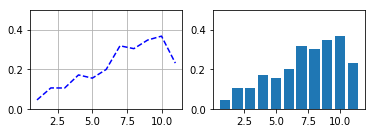

In [35]:
import matplotlib.pyplot as plt 

plot_data = g[['shown', 'prob']]
def get_len(x):
    return len(x.split())

def plot_mean_prob_distribution(plot_data, y_lbl):
    plot_data['context_len'] = plot_data.shown.apply(get_len)
    x1 = plot_data.groupby('context_len').sum()
    x1 = x1.reset_index(level=['context_len'])
    x2 = plot_data.groupby('context_len').size()
    x2 = x2.reset_index(level=['context_len'])
    plotting = x1.merge(x2, left_on = 'context_len', right_on = 'context_len', how = 'outer')
    plotting.columns = ['context_len', 'prob', 'abs_freq']
    plotting['frequency'] = plotting['prob']/plotting['abs_freq']
    
    plt.subplot(221)
    plot1, =plt.plot(plotting.context_len.tolist(), plotting.frequency.tolist(), 'b--', label="$y=x^2$")
    plt.ylim(0,y_lbl)
    plt.grid()

    plt.subplot(222)
    plt.bar(x= plotting.context_len.tolist(), height = plotting.frequency.tolist())
    plt.ylim(0,y_lbl)

    _=plt.show()
    
plot_mean_prob_distribution(plot_data, 0.5)

Compute median and plot it. Why it is also necessary? Because the median values are more stable and less dependant on the "emmissions" of the model.

/home/semen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/semen/.local/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


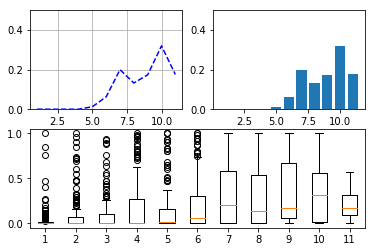

In [18]:
import numpy as np

def tl(x):
    d = []
    d.append(x)
    return d

def mediann(x):
    return np.median(x)

def plot_median_distribution(plot_data, y_lbl):
    
    plot_data['context_len'] = plot_data.shown.apply(get_len)
    plot_data.prob = plot_data.prob.apply(tl)
    x1 = plot_data.groupby('context_len').sum()
    x1 = x1.reset_index(level=['context_len'])
    plotting = x1

    plotting['mediann'] = plotting['prob'].apply(mediann)
    
    data = np.array(plotting.prob)

    plt.subplot(221)
    plot1, =plt.plot(plotting.context_len.tolist(), plotting.mediann.tolist(), 'b--', label="$y=x^2$")
    plt.ylim(0,y_lbl)
    plt.grid()

    plt.subplot(222)
    plt.bar(x= plotting.context_len.tolist(), height = plotting.mediann.tolist())
    plt.ylim(0,y_lbl)
    
    plt.subplot(212)
    plt.boxplot(data)
    

    _=plt.show()

    
plot_median_distribution(plot_data, 0.5)

## LSTM Data

In [11]:
lstm = pd.read_excel('LSTM_prob_w_pos.xlsx')

In [12]:
lstm[['shown','answer']].drop_duplicates().shape

(1312, 2)

In [13]:
sub_lstm = lstm[['shown','answer', 'prob', 'pos.tag']]
sub_lstm = sub_lstm[sub_lstm.shown != 'Введите первое слово']
sub_lstm.shape

(1223, 4)

/home/semen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


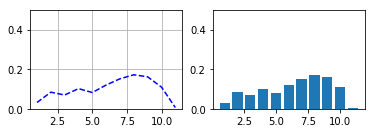

In [14]:
plot_data_lstm = sub_lstm[['shown', 'prob']]
plot_mean_prob_distribution(plot_data_lstm, 0.5)

/home/semen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


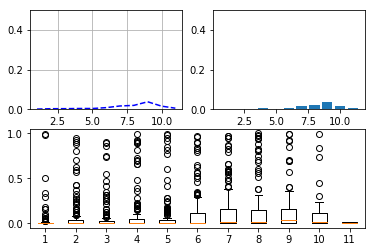

In [15]:
plot_median_distribution(plot_data_lstm,0.5)

In [16]:
ggg = g.merge(sub_lstm, left_on=['shown','word.id'], right_on=['shown','answer'], how='outer')
ress = ggg[['shown','word.id', 'prob_x', 'confusion', 'prob_y', 'pos.tag']]
ress.head()

,shown,word.id,prob_x,confusion,prob_y,pos.tag
0,А,промывать,0.000000,0.978571,1.986770e-07,INFN
1,А промывать,манную,0.000000,0.978571,9.952960e-06,ADJF
2,А промывать манную,крупу,0.333333,0.978571,9.152956e-02,NOUN
3,А промывать манную крупу,перед,0.000000,0.978571,7.796750e-04,PREP
4,А промывать манную крупу перед,тем,0.000000,0.978571,1.503523e-02,CONJ


## Comparing

In [17]:
ress['diff'] = (ress.prob_x - ress.prob_y)**2
print(sum(ress['diff']))

55.21226830615383


/home/semen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


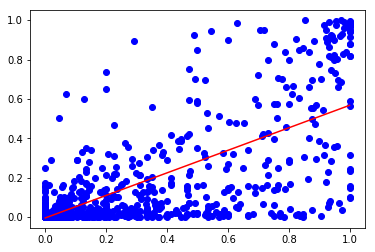

In [18]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats

gradient, intercept, r_value, p_value, std_err = stats.linregress(ress.prob_x, ress.prob_y)
mn=np.min(ress.prob_x)
mx=np.max(ress.prob_y)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(ress.prob_x,ress.prob_y,'ob')
plt.plot(x1,y1,'-r')
plt.show()

In [19]:
from sklearn.metrics import mutual_info_score
MI = mutual_info_score(ress.prob_x, ress.prob_y)
MI

3.6634010037120004

## Cloze task pos tagging with pymorthy

In [22]:
data = row_data[['shown','answer','word.id']]
k = data[['shown','word.id']].drop_duplicates()
k.shape

(1222, 2)

In [23]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def pos_t_cor_w(cor_w):
    ps = {}
    for indx, pos_variant in enumerate(morph.parse(cor_w)):
        if pos_variant.tag.POS not in ps:
            ps[pos_variant.tag.POS] = pos_variant.score
        else:
            ps[pos_variant.tag.POS] += pos_variant.score
            
    return list(ps.items())

In [24]:
correct_word_tags = {}
for context, word in list(zip( k['shown'].tolist(), k['word.id'].tolist())):
    correct_word_tags[(context,word)] = pos_t_cor_w(word)

In [25]:
def tolist_(x):
    return [x]
data.answer = data.answer.apply(tolist_)

In [26]:
nt = data[['shown', 'answer', 'word.id']].groupby(['shown', 'word.id']).sum()
nt = nt.reset_index()
nt.head()

,shown,word.id,answer
0,А,промывать,"[вот, где, ему, зачем, знаете, зори, когда, кт..."
1,А промывать,манную,"[глаза, горло, желудок, ли, макароны, мозги, м..."
2,А промывать манную,крупу,"[кашу, кашу, кашу, кашу, кашу, кашу, кашу, каш..."
3,А промывать манную крупу,перед,"[блин, лучше, лучше, не, не, не, не, не, не, н..."
4,А промывать манную крупу перед,тем,"[варкой, варкой, варкой, варкой, варкой, варко..."


In [27]:
f = list(zip(nt['shown'].tolist(), nt['word.id'].tolist()))
answer_dict = {}
for indx,i in enumerate(f):
    answer_dict[i] = nt.answer.tolist()[indx] 

In [28]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
def pos_t_ans(true_tag_distr, answers):
    normalize = len(answers)
    res = 0
    for answer in answers:
        ps = {}
        for indx, pos_variant in enumerate(morph.parse(answer)):
            if pos_variant.tag.POS not in ps:
                ps[pos_variant.tag.POS] = pos_variant.score
            else:
                ps[pos_variant.tag.POS] += pos_variant.score
     
        for tag, prob in true_tag_distr:
            if tag in ps:
                res += ps[tag]*prob
    res /=normalize     
        
    return res

In [29]:
i = 0
res = []
for cont_word, answers in answer_dict.items():
    res.append(pos_t_ans(correct_word_tags[cont_word],answers))
print(len(res))
nt['prob'] = res

1222


/home/semen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


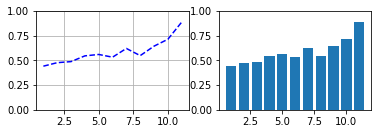

In [30]:
plot_data = nt[['shown', 'prob']]
plot_mean_prob_distribution(plot_data,1)

/home/semen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


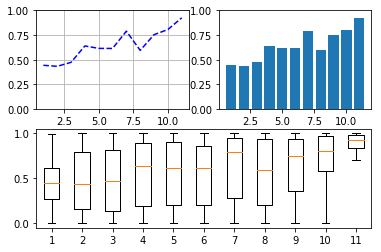

In [31]:
plot_median_distribution(plot_data,1)

## LSTM data pos tagging

In [6]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
import re
def pos_t_ans(answers_prob):
    tags_prob = {'NOUN':0, 'ADJF':0, 'ADJS':0,'COMP':0,'VERB':0,'INFN':0,
'PRTF':0,'PRTS':0, 'GRND':0, 'NUMR':0, 'ADVB':0, 'NPRO':0, 'PRED':0,
'PREP':0, 'CONJ':0,'PRCL':0,'INTJ':0}
    tags_count = {'NOUN':0, 'ADJF':0, 'ADJS':0,'COMP':0,'VERB':0,'INFN':0,
'PRTF':0,'PRTS':0, 'GRND':0, 'NUMR':0, 'ADVB':0, 'NPRO':0, 'PRED':0,
'PREP':0, 'CONJ':0,'PRCL':0,'INTJ':0}
    for answer,prob in answers_prob:
        k = re.findall('[а-яА-Я]+',answer)
        if len(k)>0:
            answer = k[0]
            for indx, pos_variant in enumerate(morph.parse(answer)):
                if pos_variant.tag.POS!=None:
                    tags_prob[pos_variant.tag.POS] += (pos_variant.score)
                    #tags_prob[pos_variant.tag.POS] += (pos_variant.score*prob)
                    if pos_variant.score>0:
                        tags_count[pos_variant.tag.POS] += 1

    t_p = list(tags_prob.items())
    t_p.sort(key = lambda x:x[1])
    pos, prob = t_p[-1]
    if prob!=0:
        prob /=tags_count[pos]
    return pos, prob

In [7]:
import json
json_data=open('data.json').read()
data = json.loads(json_data)
lstm_tag_max_prob = []
lstm_best_tag = []
for context in list(data.keys()):
    pos, prob = pos_t_ans(data.get(context))
    lstm_tag_max_prob.append((context,prob))
    lstm_best_tag.append((context,pos))
print(len(lstm_best_tag))

1187


In [8]:
Context = [i for i, j in lstm_tag_max_prob]
Probs_lstm_tag = [j for i, j in lstm_tag_max_prob]
lstm_best_tag = [j for i, j in lstm_best_tag]
lstm_tags_prob = pd.DataFrame({'shown' :Context, 'prob' : Probs_lstm_tag, 'tag':lstm_best_tag })
lstm_tags_prob.head()


,shown,prob,tag
0,на,0.397501,NOUN
1,на болотах,0.738495,VERB
2,на болотах оставался,0.243669,ADJF
3,на болотах оставался ещё,0.385341,ADJF
4,на болотах оставался ещё лёд,0.303169,NOUN


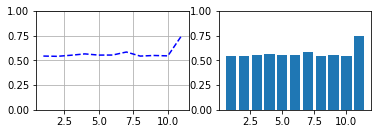

In [20]:
def prep(x):
    h = x.replace(' - ', '-')
    h = h.replace(' : " ', ' ')
    return h
plot_data = lstm_tags_prob[['shown', 'prob']]
plot_data.shown = plot_data.shown.apply(prep)
plot_mean_prob_distribution(plot_data, 1)

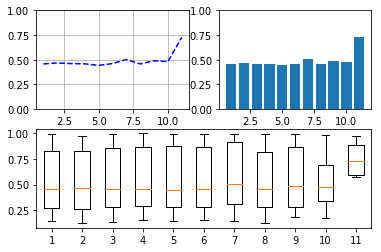

In [21]:
plot_median_distribution(plot_data,1)

## Tag models comparing

In [32]:
lstm_tags_prob['diff'] = (nt['prob'] - lstm_tags_prob.prob)**2
print(sum(lstm_tags_prob['diff']))

234.3961547021695


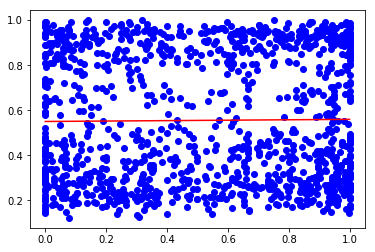

In [33]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats


gradient, intercept, r_value, p_value, std_err = stats.linregress(nt['prob'][:1187], lstm_tags_prob.prob)
mn=np.min(nt['prob'][:1187])
mx=np.max(lstm_tags_prob.prob)
x1=np.linspace(mn,mx,500)
y1=gradient*x1+intercept
plt.plot(nt['prob'][:1187],lstm_tags_prob.prob,'ob')
plt.plot(x1,y1,'-r')
plt.show()

In [34]:
from sklearn.metrics import mutual_info_score
MI = mutual_info_score(lstm_tags_prob.prob, nt['prob'][:1187])
MI

6.722463492206198

## Cloze task data semantic research

In [44]:
h = open('Close_task_answers.vec.vec', 'r').readlines()
word2ind = {}
vecs = []
for ind, j in enumerate(h[1:]):
    word2ind[j.split(' ')[0]] = ind
    vecs.append(j.split(' ')[1:])

In [45]:
import numpy as np
from sklearn.cluster import KMeans
km = KMeans(n_clusters=40, init='k-means++', n_init=10, max_iter=500).fit_predict(np.array(vecs))

In [46]:
ind2word = {j:i for i,j in word2ind.items()}

In [47]:
clusters = []
for word_cluster in range(40):
    new_cluster = []
    for ind, i in enumerate(km):
        if i == word_cluster:
            new_cluster.append(ind2word[ind])
    clusters.append(new_cluster)
print(sum(len(i) for i in clusters))

9294


In [49]:
for i in [j[:10] for j in clusters]:
    print (', '.join(i))
    print('###############################')


была, она, которая, стала, эта, первая, должна, получила, вышла, та
###############################
увидел, стоял, бежал, спас, упал, поднялся, сел, встал, поднял, разбил
###############################
чтобы, сделать, использовать, найти, делать, писать, работать, оставить, стать, создать
###############################
болезни, крови, врач, лечения, тяжело, больных, больницы, кровь, болезнь, больнице
###############################
жизни, жизнь, мир, любовь, образ, голос, природы, любви, ради, бога
###############################
однажды, случайно, ночью, домой, убить, любит, неожиданно, утром, вдруг, вечером
###############################
были, стали, известные, появились, могли, получили, начали, жители, вошли, работали
###############################
растений, растения, леса, листья, дерево, насекомые, лесной, деревьев, дерева, ветви
###############################
смерти, род, родился, сын, женщин, отец, детей, семье, мужчин, дочь
###############################
нам, ты, моя, на